<a href="https://colab.research.google.com/github/Gioalf/AH2179/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Revealing representative "typical" day-types using traffic data observation and clustering

Clustering is a way of letting the data tell us its own story. Instead of assuming traffic always follows the same daily rhythm, we will use clustering to discover “typical day-types”: weekdays, weekends, holidays, incidents, straight from sensor observations. By the end of this exercise, you will learn how to prepare temporal data for clustering, explore it and reflect on what the patterns might mean for managing roads in practice.

Objective: find, evaluate and choose a clustering of daily time-series (day-profiles), and show how that clustering helps a simple prediction task.

what this notebook does:

Data loading & Exploratory Data Analysis (visualize raw day profiles).
Preprocessing
Baseline experiments (k-means), time-series alternatives (k-Shape or DTW), and at least one density/soft model (GMM/DBSCAN).
Internal evaluation (silhouette, Calinski-Harabasz, Davies-Bouldin) + stability checks.
Time-aware external evaluation using the centroid-based historical-mean predictor (RMSE, MAPE).
Interpretation: centroids, representative days and weekday distribution
Glossary
day-profile / day-matrix: one row = one day; columns = 5-minute buckets.
centroid historical-mean predictor: for each cluster, predict a day by using the cluster centroid (or average of historical days assigned to that cluster).

## Data preparation

In [ ]:
import pandas as pd
import numpy as np
#upload the dataset by downloading both datasets from canvas and upload it on colab

data_df = pd.read_csv("/content/dataset_exercise_5_clustering_highway_traffic (1).csv",sep=";")
data_df

,PORTAL,Date,time_from,time_to,Interval_5,SPEED_MS_AVG,flow
0,"E4S 56,780",20210101,00:00:00,00:05:00,0,18.56,39
1,"E4S 56,780",20210101,00:05:00,00:10:00,1,20.39,18
2,"E4S 56,780",20210101,00:10:00,00:15:00,2,19.27,26
3,"E4S 56,780",20210101,00:15:00,00:20:00,3,19.52,52
4,"E4S 56,780",20210101,00:20:00,00:25:00,4,20.52,52
...,...,...,...,...,...,...,...
104838,"E4S 56,780",20211231,23:35:00,23:40:00,283,19.58,115
104839,"E4S 56,780",20211231,23:40:00,23:45:00,284,19.47,87
104840,"E4S 56,780",20211231,23:45:00,23:50:00,285,19.77,130
104841,"E4S 56,780",20211231,23:50:00,23:55:00,286,18.79,129


The provided dataset contains 5-minute observations on one highway microwave sensor and needs to be in a format ready for clustering. Clustering doesn’t work on raw tables, it needs a structured representation. In this section, we will take the raw sensor data and reformat it so that each entire day becomes a single data vector. This makes it possible to compare whole days against each other.

Here’s the logic: a day is 24 hours long, and with 5-minute measurements that means 288 data points. If we line these up in order, we can represent each day as a 288-dimensional vector: one row per day, one column per time slot. Later, clustering will group these day-vectors into families of “similar days.” This is "giving every day its own fingerprint."

In [ ]:
# Sort the DataFrame 'data_df' by columns "Date" and "Interval_5"
data_df.sort_values(["Date", "Interval_5"])

# Extract unique dates from the sorted DataFrame
days = np.unique(data_df[['Date']].values.ravel())
# Calculate the total number of unique days
ndays = len(days)

# Group the DataFrame 'data_df' by the "Date" column
day_subsets_df = data_df.groupby(["Date"])

# Define the total number of 5-minute intervals in a day
nintvals = 288

# Create a matrix 'vectorized_day_dataset' filled with NaN values
vectorized_day_dataset = np.zeros((ndays, nintvals))
vectorized_day_dataset.fill(np.nan)

# Loop through each unique day
for i in range(0, ndays):
    # Get the DataFrame corresponding to the current day
    df_t = day_subsets_df.get_group(days[i])

    # Loop through each row in the current day's DataFrame
    for j in range(len(df_t)):
        # Get the current day's DataFrame
        df_t = day_subsets_df.get_group(days[i])

        # Extract the "Interval_5" and "flow" values and populate 'vectorized_day_dataset'
        vectorized_day_dataset[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]

# Print the resulting 'vectorized_day_dataset'
print(vectorized_day_dataset)

/tmp/ipython-input-2050002240.py:22: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_t = day_subsets_df.get_group(days[i])
/tmp/ipython-input-2050002240.py:27: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_t = day_subsets_df.get_group(days[i])


[[ 39.  18.  26. ...  32.  39.  34.]
 [ 30.  32.  27. ...  44.  41.  39.]
 [ 36.  44.  52. ...  50.  45.  23.]
 ...
 [ 20.  34.  31. ...  38.  42.  36.]
 [ 36.  40.  25. ...  38.  56.  35.]
 [ 33.  32.  34. ... 130. 129. 117.]]


Recap of the steps the code did:

STEP 1:We sorted the data to guarantee chronological order.
STEP 2:We pulled out all unique days, so we know how many daily profiles we need.
STEP 3:We fixed the number of time slots (288) so every day has the same length.
STEP 4:We built a big empty matrix, one row per day, one column per 5-minute slot.
STEP 5:Finally, we filled this matrix: for each day, we inserted the flow values into the right time slots.
The result: a clean “day × time” dataset ready for clustering. From here on, each row can be treated like a single point in a 288-dimensional space.

Note that if you plan to reveal network-wide day-types (more sensors), this day vector can be ordered vector of SENSORS * TIME-INTERVALS.

# Part 1: Data exploration

# 1.1 : Missing values and outliers

Before we trust this matrix, we need to explore it. Clustering algorithms are very sensitive to missing values and outliers: a single "bad day" can distort entire clusters. Let’s check for gaps and anomalies before we hand the data to the clustering algorithm.

In [ ]:

print('number of nans',np.sum(np.isnan(vectorized_day_dataset)))
print('rate of nans',np.sum(np.isnan(vectorized_day_dataset))/(ndays*nintvals))

number of nans 277
rate of nans 0.0026350837138508373


The quick check shows only 277 missing entries, which is just 0.26% of the data. That is very low but missingness is rarely random. In traffic data, it could mean times when no vehicles were detected (night hours) or moments when sensors temporarily failed. Spotting where/when these gaps happen helps us decide whether to ignore them, fill them in or treat them as a signal themselves.

(288,)


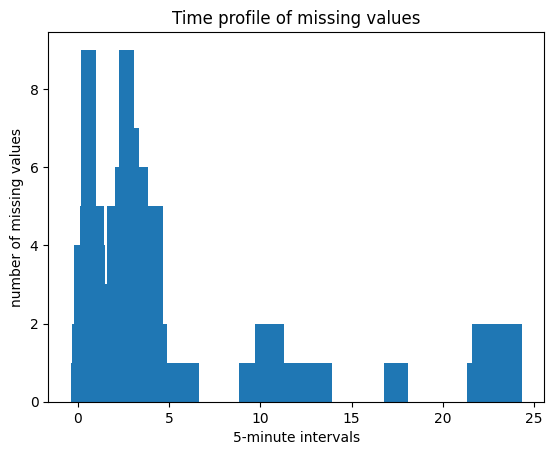

In [ ]:
nans_per_time = np.sum(np.isnan(vectorized_day_dataset),0)
print(nans_per_time.shape)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# Create an array 'x_axis' representing the 5-minute intervals
x_axis = np.arange(0, nintvals, 1, dtype=int)
# Initialize an empty list 'x_axis_hours' to store time values in hours
x_axis_hours = []
# Convert interval indices to hours and append them to 'x_axis_hours'
for i in range(0, len(x_axis)):
  x_axis_hours.append(float(x_axis[i]*5)/60)
ax.bar(x_axis_hours,height=nans_per_time)


ax.set_ylabel('number of missing values')
ax.set_xlabel('5-minute intervals')
ax.set_title('Time profile of missing values')

plt.show()

Are these missing values associated with just a few days?

In [ ]:
nans_per_day = np.sum(np.isnan(vectorized_day_dataset),1)
print('number of days with missing value',np.size(np.where(nans_per_day > 0),1))

number of days with missing value 28


# Part 1.2 : Daily profile of flow dynamic

Visualizing traffic flow across time of day reveals the heartbeat of the system. What does the data look like? What is the traffic pattern? You should expect sharp rises around commuting hours and dips overnight. These daily profiles are important because clustering algorithms will later decide “similarity” based on the shapes of these curves. When you see peaks or irregular bumps, think about what real world behaviors they correspond to: work commute, evening leisure, freight transport.

Below is the script that can help you visualize all days where overlapping transparencies highlight some patterns. The black line is the average yearly flow for a time interval.

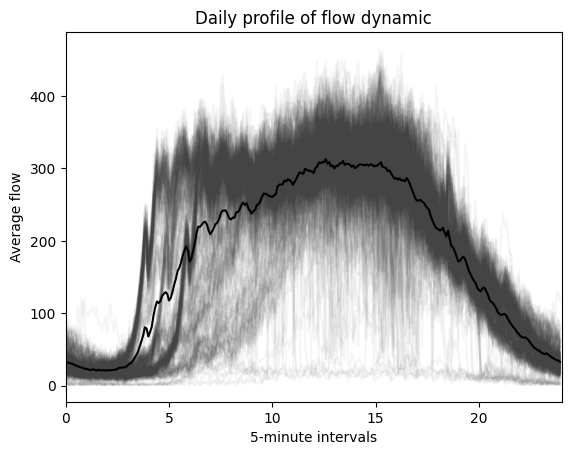

In [ ]:
# Create a new figure and axis object using subplots
fig, ax = plt.subplots()# a convenient way to create a new figure and a set of subplots.
ax.plot(np.array([x_axis_hours,]*ndays).transpose(),vectorized_day_dataset.transpose(),color='#444444',alpha=0.05)
# Above line plots the dataset with specified color and transparency.
ax.plot(x_axis_hours,np.transpose(np.nanmean(vectorized_day_dataset,0)),color='black')
# Above line plots the average of the dataset in black color.

ax.set_ylabel('Average flow')
ax.set_xlabel('5-minute intervals')
plt.xlim(0,24)
ax.set_title('Daily profile of flow dynamic')

plt.show()

Boxplots compress the daily data into distributions for each 5-minute slot. They tell us not only the average but also the spread and the outliers. Below is the code to visualize these boxplots

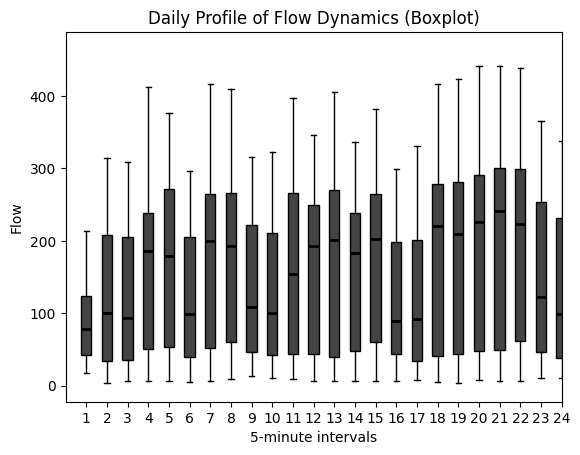

In [ ]:
# Create a new figure and axis object using subplots
fig, ax = plt.subplots()  # This line is a convenient way to create a new figure and a set of subplots.

# Create a boxplot for the dataset
boxplot = ax.boxplot(vectorized_day_dataset.T, patch_artist=True)

# Customize the boxplot appearance
for patch in boxplot['boxes']:
    patch.set_facecolor('#444444')  # Set the box color to gray
for median in boxplot['medians']:
    median.set(color='black', linewidth=2)  # Set median line color to black

# Set the y-axis label
ax.set_ylabel('Flow')

# Set the x-axis label
ax.set_xlabel('5-minute intervals')

# Set the x-axis limits to be between 0 and 24
plt.xlim(0, 24)

# Set the title of the plot
ax.set_title('Daily Profile of Flow Dynamics (Boxplot)')

# Display the plot
plt.show()

Notice whether morning peaks are tight (predictable) or wide (variable). Wide distributions could mean more “noise” for clustering, the algorithm will find it harder to decide what is typical for that time slot.

By averaging days into weekdays vs. weekends, we test a very human hypothesis: “Mondays don’t look like Sundays.” Do the curves confirm it? This step bridges human intuition (calendar categories) with machine learning exploration (clustering). Later, we’ll see whether the algorithm rediscovers these patterns or finds something subtler, like holiday effects.

In [ ]:
import datetime

# Create an array 'day_of_week' to store the day of the week for each unique date
day_of_week = np.zeros((ndays))

# Loop through each unique date
for i in range(0, ndays):
    # Parse the current date from a string to a datetime object
    day_dt = datetime.datetime.strptime(str(days[i]), '%Y%m%d')

    # Get the day of the week (1 for Monday, 2 for Tuesday, ..., 7 for Sunday)
    day_of_week[i] = day_dt.isoweekday()

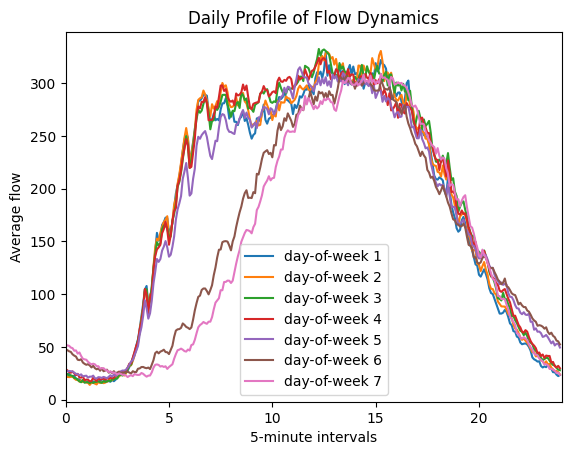

In [ ]:
# Create a new figure and axis object using subplots
fig, ax = plt.subplots()

# Iterate through each day of the week (from 1 to 7)
for i in range(1, 8):
    # Find the indices of days that correspond to the current day of the week
    day_of_week_index_t = np.where(day_of_week == i)

    # Calculate the number of days that match the current day of the week
    ndays_t = np.size(day_of_week_index_t[0])

    # Plot the average flow for the current day of the week
    ax.plot(x_axis_hours,
            np.nanmean(vectorized_day_dataset[day_of_week_index_t[0], :].transpose(), 1),
            label='day-of-week ' + str(i))
    # This line plots the average flow for the current day of the week.
    # 'np.nanmean()' calculates the mean while handling NaN values.

# Set the y-axis label
ax.set_ylabel('Average flow')

# Set the x-axis label
ax.set_xlabel('5-minute intervals')

# Set the x-axis limits to be between 0 and 24
plt.xlim(0, 24)

# Set the title of the plot
ax.set_title('Daily Profile of Flow Dynamics')

# Add a legend indicating the day of the week
ax.legend()

# Display the plot
plt.show()

The day's index is from 1 - 7, where 1 is Monday. To our expectations, we can see the difference between weekdays and weekends. So far, we’ve established that traffic days differ in systematic ways: weekday/weekend, time-of-day peaks, occasional anomalies. Clustering will now formalize these differences into groups. The goal is to let the algorithm discover with patterns that we might not have thought to test manually. This we explore with clustering in the next part of the exercise.

# Part 2: Clustering

In the previous section, we explored our data and prepared it for analysis. Now, we reach the core of our task: clustering. Our goal is to group similar days together to discover common daily traffic patterns, or "day-types."

We face a fundamental question in clustering: how many clusters (k) are there? There is no single "correct" answer; it depends on the story the data tells and our analytical goals. Once we have our clusters, we will visualize the resulting day-types (cluster centroids) and analyze their characteristics to understand what each "typical day" represents ( a weekday rush hour pattern, a quiet weekend pattern, incidents)

## Clustering

Using clustering methods in scikit-learn is relatively simple, as shown below. With one line of code, you can get some clusters. However, this will need some work to search for representative clusters. This is the first step to pattern exploration.

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

#clusters = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(vectorized_day_dataset)


As you can see k-means clustering method can not handle missing values, so you have choices: impute data or remove them. We will just remove all days that have missing observations. Fewer days would be removed if we restrict the clustering to a particular day-time period, 06:00 - 22:00:00. Below, we prepare a new dataset without missing values and update the list of days for later visualization purposes.

In [ ]:
n_clusters = 10
clusters = None
#print(np.where(nans_per_day > 0)[0])
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

# BELOW lines enables you to comment in and out clustering method you want to use note that GMM have different ouput and thus labels are extracted differently
# clusters = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# clusters = AgglomerativeClustering(n_clusters=n_clusters,metric='euclidean', linkage='ward').fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
clusters = DBSCAN(eps=500, min_samples = 2).fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

if clusters is not None:
  cluster_labels = clusters.labels_

#cluster_labels = GaussianMixture(n_components=n_clusters).fit(vectorized_day_dataset_no_nans).predict(vectorized_day_dataset_no_nans) #check the parameters at  https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_init.html#sphx-glr-auto-examples-mixture-plot-gmm-init-py


print(cluster_labels)

[-1  0  0 -1  1  0  1  1  0  0 -1 -1 -1 -1 -1  0  0  1 -1  1  1  1  0  0
 -1 -1 -1  1  0  0 -1 -1 -1 -1 -1  0  0  1  1  1 -1  1  0  0  1  1  1 -1
  0  0  1 -1 -1 -1  0  0  1  1 -1  1 -1  0  0  1 -1  1 -1  1  0  0  1  1
  1 -1  1  0  0  1 -1 -1 -1  1  0 -1 -1 -1  0  0  0 -1  1  1 -1  0  0 -1
  1  1 -1  1  0  0  1 -1  1  1 -1  0  0 -1  1 -1 -1 -1  0  2  3  3  3 -1
 -1  2  2 -1 -1 -1 -1  4  2  2 -1 -1  2  2 -1  3  3  3 -1  2  2 -1 -1 -1
  3 -1 -1  2  3  3 -1 -1 -1 -1  2 -1 -1  3  3 -1  2  2  3 -1 -1  3 -1 -1
  2 -1 -1 -1 -1 -1  2 -1 -1 -1  4  2  2  4  4 -1  4  4  2  2  4 -1  4  4
  4  2  2  4 -1  2  2  4 -1  4 -1  2  2 -1 -1 -1  4 -1 -1  2  3 -1 -1 -1
 -1  2 -1 -1  3 -1 -1 -1 -1  2  3  3  3 -1 -1 -1  3  2  2  3  3 -1  3 -1
  2  2  3  3 -1 -1 -1  2 -1 -1  3 -1 -1 -1 -1 -1  3 -1 -1 -1 -1  3  3 -1
 -1 -1 -1  3  3 -1 -1  2 -1 -1 -1  3  3  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1  0 -1  5 -1 -1 -1 -1  0 -1
 -1 -1 -1 -1  0  0  5  5 -1 -1 -1  0  0 -1 -1 -1 -1

In [ ]:
clusters

KMeans(n_clusters=10, random_state=0)

In [ ]:
vectorized_day_dataset_no_nans

array([[ 39.,  18.,  26., ...,  32.,  39.,  34.],
       [ 30.,  32.,  27., ...,  44.,  41.,  39.],
       [ 36.,  44.,  52., ...,  50.,  45.,  23.],
       ...,
       [ 20.,  34.,  31., ...,  38.,  42.,  36.],
       [ 36.,  40.,  25., ...,  38.,  56.,  35.],
       [ 33.,  32.,  34., ..., 130., 129., 117.]])

## Visualizaiton of representative day-type patterns

### Special plots for visualizing day-type patterns

the results of clusterings are assignments to the clusters, this can be hard to read and make conclusions about it, so visualization of data in right way is of high importance. Below is a script gives you set of libraries for calendar and centroid visualizaiton.

***Note: The below script you do not have to understand. Consider it as an external library that will plot for you, just like a histogram plot, for which you also do not know the exact implementation. Anyway, this course does not focus on information visualization.***

In [ ]:

from dateutil.relativedelta import relativedelta
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib import colors

def assign_colors(n_clusters, days, assigments):

    days_colors = []
    color_to_cluster = []
    style_to_cluster = []
    weekend_colors = ['#67001f','#d6604d','#fdae61','#f46d43','#d53e4f','#9e0142','#f768a1','#f1c232']#,'#fe9929','#cc4c02','#e31a1c','#737373','#bdbdbd','#252525','#bcbddc']
#    weekend_school_colors = ['#c2a5cf','#f1b6da','#8e0152','#c51b7d','#de77ae','#ae017e','#fcc5c0','#e31a1c','#737373','#bdbdbd']
#    bank_holidays_colors = ['#543005','#dfc27d','#bf812d','#8c510a']
    mixed_colors = ['#4d4d4d','#35978f','#bababa','#878787']
    weekday_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#cab2d6','#6a3d9a','#b15928','#8dd3c7','#bebada','#fb8072','#b3de69','#bc80bd','#fccde5','#ccebc5','#35978f','#80cdc1']

    cluster_id_weekdays_share = []
    cluster_id_weekend_share = []
    cluster_id_all_days = []

    for i in range(0,n_clusters):
        color_to_cluster.append(None)
        style_to_cluster.append(None)
        cluster_id_weekdays_share.append(0)
        cluster_id_weekend_share.append(0)
        cluster_id_all_days.append(0)

    for i in range(0,len(days)):
        #print(i,assigments[i],len(assigments),len(cluster_id_all_days))
        if assigments[i] is not None:
            cluster_id_all_days[assigments[i]] += 1
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')

            if int(pomT.weekday()) < 5:
                cluster_id_weekdays_share[assigments[i]] += 1
            else:
                cluster_id_weekend_share[assigments[i]] += 1

    print('cluster_id_weekdays_share',cluster_id_weekdays_share)
    print('cluster_id_weekend_share',cluster_id_weekend_share)
    for i in range(0,len(days)):
        if assigments[i] is not None:
            cluster_idx = assigments[i]
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
            if color_to_cluster[assigments[i]] is None:
                if cluster_id_weekend_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekend_colors.pop()
                        style_to_cluster[assigments[i]] = ':'
                elif cluster_id_weekdays_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekday_colors.pop(0)
                        style_to_cluster[assigments[i]] = '-'
                else:
                    color_to_cluster[assigments[i]] = mixed_colors.pop()
                    style_to_cluster[assigments[i]] = ':'

            days_colors.append(color_to_cluster[assigments[i]])
        else:
            days_colors.append(None)

    return days_colors,color_to_cluster,style_to_cluster


def calmap(ax, year, data, days, assigments, n_clusters,days_colors,color_to_cluster,
           limit_graphics=False):

    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders

    xticks, labels = [], []
    start = datetime.datetime(year,1,1).weekday()

    for month in range(1,13):

        first = datetime.datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]

        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",

                       linewidth=1, zorder=20, clip_on=False)

        ax.add_artist(poly)

    line = Line2D([0,53],[5,5],linewidth=1, zorder = 20,color="black",linestyle='dashed')
    ax.add_artist(line)

    if not limit_graphics:
        ax.set_xticks(xticks)
        ax.set_xticklabels(labels)
        ax.set_yticks(0.5 + np.arange(7))
        ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
        ax.set_title("{}".format(year), weight="semibold")
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False)

    # Clearing first and last day from the data
    valid = datetime.datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime.datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    for i in range(0,len(days)):
        if '-' in str(days[i]):
            pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
        else:
            pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
        week_number = int(pomT.strftime("%W"))
        day_of_week = int(pomT.weekday())
        data[day_of_week,week_number] = assigments[i]


    act_date = datetime.datetime(year,1,1)
    while (act_date.year == year):

        week_number = int(act_date.strftime("%W"))
        day_of_week = int(act_date.weekday())
        doy_id = act_date.timetuple().tm_yday
        if doy_id<5 and week_number > 53:
            week_number = 0

        act_date = act_date + datetime.timedelta(days=1)

    #pomT = datetime.datetime.strptime('2017-01-01','%Y-%m-%d')
    #week_number = int(pomT.strftime("%V"))
    #day_of_week = int(pomT.weekday())
    #print(week_number,day_of_week)
    #doy_id = pomT.timetuple().tm_yday
    #if doy_id<5 and week_number > 0:
    #    week_number = 0
    #data[day_of_week,week_number] = len(clusters)+10

    # Showing data
    cmap = plt.cm.spring  # Can be any colormap that you want after the cm
    cmap.set_bad(color='white')

    #ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=0, vmax=len(clusters)+10,
    #          cmap=cmap, origin="lower", alpha=.75)

    cmap = colors.ListedColormap(color_to_cluster)
    bounds=[-0.1]
    step = 1
    for i in range(0,n_clusters):
        bounds.append(i-0.1+step)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    #print(color_to_cluster)
   #print(bounds)
    #print(norm)

    #print(color_to_cluster)
    #print(bounds)
    #print(cmap)
    #exit(0)

    ax.imshow(data, extent=[0,53,0,7], zorder=10, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)

def make_calendar_visualization_figure(days,assigments,n_clusters,years,days_colors,color_to_cluster,
                                       save_figure: str = None, show_figure:bool = True, limit_graphics = False):

    fig = plt.figure(figsize=(8,1.5*len(years)), dpi=100)
    X = np.linspace(-1,1, 53*7)

    for i, obj in enumerate(years):

        pom_s = str(len(years))+'1'+str(i+1)
        print(pom_s)

        ax = plt.subplot(int(pom_s), xlim=[0, 53], ylim=[0, 7], frameon=False, aspect=1)
        I = 1.2 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
        I = I.reshape(53,7).T
        I.fill(np.nan)
        calmap(ax, int(obj), I.reshape(53,7).T, days, assigments, n_clusters,days_colors,color_to_cluster, limit_graphics)

    #   ax = plt.subplot(212, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #  I = 1.1 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #   calmap(ax, 2018, I.reshape(53,7).T)

    #ax = plt.subplot(313, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #I = 1.0 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #calmap(ax, 2019, I.reshape(53,7).T)
    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()


def make_figure_centroids(x,y,color_to_cluster,style_to_cluster,cluster_ids,minY = None,maxY = None,
                          save_figure: str = None, show_figure:bool = True):

    #print(color_to_cluster)
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(111)
    for i in range(0,len(x)):
        #print(i,color_to_cluster[i],style_to_cluster[i])
        #print(y[i])
        ax.plot(x[i],y[i],style_to_cluster[i], color=color_to_cluster[i], label=str(cluster_ids[i]))
    ax.set_xlabel('Time of day')
    ax.set_ylabel('Flow')
    if minY is not None and maxY is not None:
        ax.set_ylim([minY, maxY])
    plt.legend()

    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()



### Visualization

#### Calendar visualization

Using the above functions for visualization, the representative day-type clusters can be seen in a calendar form in order to enable us by-eye analysis to make sense of these clusters. Do cluster labels form temporally coherent patterns when viewed across a calendar? In particular, do weekends, holidays or seasonal cycles explain cluster placement? Note that white cells are removed days because of missing observations

cluster_id_weekdays_share [2, 37, 3, 32, 14, 3, 145]
cluster_id_weekend_share [44, 0, 35, 0, 0, 0, 22]
111


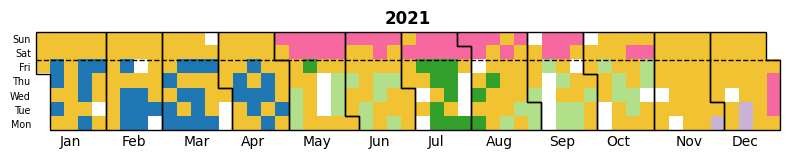

In [ ]:
# Calculate the number of clusters by finding unique values in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)
# This function 'make_calendar_visualization_figure' is used to generate a visualization based on the provided data and parameters.
# 'days_not_nans' are the days, 'cluster_labels' are the cluster labels, 'n_clusters_t' is the number of clusters,
# '[2021]' represents the year, 'days_colors' represent the assigned colors for each day, 'color_to_cluster' maps colors to clusters,
# and 'save_figure' is an optional parameter to save the generated figure (can be None if not saving).

#### Day-time profile of centroids

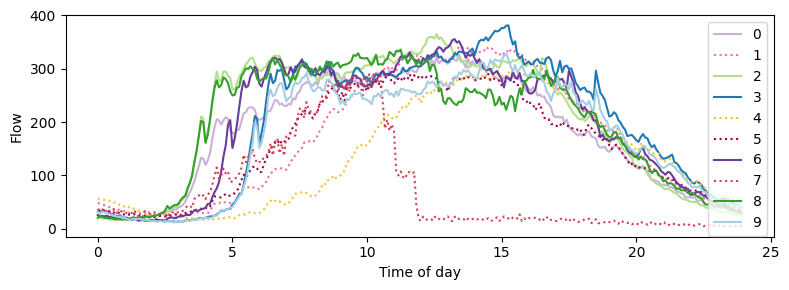

In [ ]:
# Initialize empty lists to store centroid data
centroids_xx = []  # x-axis values for centroids
centroids_yy_daytypes = []  # y-axis values for centroids, grouped by day types
cluster_ids = []  # Cluster IDs

# Iterate through each cluster
for i in range(0, n_clusters_t):
    # Store the x-axis values for centroids (hours of the day)
    centroids_xx.append(x_axis_hours)

    # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
    centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).transpose())
    centroids_yy_daytypes.append(centroid_yy)

    # Store the cluster ID
    cluster_ids.append(i)

# Generate a figure displaying the centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)
# The function 'make_figure_centroids' is used to create a visualization of the centroids,
# with the provided data and parameters.

Next, we can explore the day-type profiles. Centroids compress intra-day variability into an average, smoothness and within-cluster spread must be inspected together. A sharp, narrow peak in a centroid with small within-cluster spread implies a reliable, repeatable event. A noisy centroid suggests heterogeneity or too few members.

As you can see with first shot using k-means we can see much more day-type patterns as we may expect, it even enable to identify potential outliers/incident like cluster 7.

# Part 3: Independent work - clustering evaluation

Find the day-type clusterings that you consider most representative. Evaluate clustering quality using internal evaluation metrics such as Silhouette score and others. You can consider short-term prediction as an external metric that imitates how useful recognized patterns are compared to newly observed days. In an assignment, motivate why you consider the method selected by you as superior.

**NOTE** ***This part of exercise as well with all you have learned about clustering is the basis for your reflection in mandatory grated assignment for the MODULE 5***

You can use above and below scripts for experimenting with different methods, metrics and number of clusters

## Internal evaluation

Are clusters internally compact and well separated under the chosen metric? Below is an example for using internal metrics in scikit-learn.

In [ ]:

# Import relevant metrics from scikit-learn
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

# Calculate the Silhouette Score
SC_score = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels)
# Silhouette Score measures the quality of clusters, higher values indicate better separation.

# Calculate the Davies-Bouldin Score
DB_score = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels)
# Davies-Bouldin Score measures the average similarity between each cluster and its most similar cluster, lower values indicate better separation.

# Calculate the Calinski-Harabasz Score
CH_score = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels)
# Calinski-Harabasz Score measures the ratio of between-cluster variance to within-cluster variance, higher values indicate better separation.

# Print the computed cluster quality scores
print('Silhouette Score:', SC_score)
print('Davies-Bouldin Score:', DB_score)
print('Calinski-Harabasz Score:', CH_score)

Silhouette Score: 0.1888295110481911
Davies-Bouldin Score: 1.7434244441047695
Calinski-Harabasz Score: 81.05449965897482


Internal metrics help tune the number of clusters and preprocessing. They are necessary but not sufficient for usefulness: good silhouette does not guarantee better prediction.

##Clustering methods evaluation

I ran a few loops to perform different clustering methods with different parameters and collected all of the internal evaluation scores

In [ ]:
# Import relevant metrics from scikit-learn
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

n_clusters = [3,4,5,6,7,8,9,10,12,15]
epss = [400, 450, 500, 550, 600, 650]
k_means={}
agglomerative={}
dbscan={}
dataset=vectorized_day_dataset_no_nans

for i in n_clusters:
  # Initialize the dictionary for the current number of clusters
  k_means[i] = {}
  agglomerative[i] = {}

  clusters = KMeans(n_clusters=i, random_state=0, n_init="auto").fit(dataset)
  k_means[i]['labels'] = clusters.labels_
  k_means[i]['n_clust']=i
  # Initialize the evaluation dictionary
  k_means[i]['evaluation'] = {}
  k_means[i]['evaluation']['sc'] = silhouette_score(dataset, clusters.labels_)
  k_means[i]['evaluation']['db'] = davies_bouldin_score(dataset, clusters.labels_)
  k_means[i]['evaluation']['ch'] = calinski_harabasz_score(dataset, clusters.labels_)

  clusters = AgglomerativeClustering(n_clusters=i,metric='euclidean', linkage='ward').fit(dataset)
  agglomerative[i]['labels'] = clusters.labels_
  agglomerative[i]['n_clust']=i
  # Initialize the evaluation dictionary
  agglomerative[i]['evaluation'] = {}
  agglomerative[i]['evaluation']['sc'] = silhouette_score(dataset, clusters.labels_)
  agglomerative[i]['evaluation']['db'] = davies_bouldin_score(dataset, clusters.labels_)
  agglomerative[i]['evaluation']['ch'] = calinski_harabasz_score(dataset, clusters.labels_)

for e in epss:
  # Initialize the dictionary for the current eps value
  dbscan[e] = {}

  clusters = DBSCAN(eps=e, min_samples = 2).fit(dataset)
  dbscan[e]['labels'] = clusters.labels_
  dbscan[e]['n_clust'] = len(set(clusters.labels_)) - (1 if -1 in clusters.labels_ else 0)
  # Initialize the evaluation dictionary
  dbscan[e]['evaluation'] = {}
  # Silhouette and Davies-Bouldin scores are not well-defined for DBSCAN with only one cluster (or all points as noise)
  if dbscan[e]['n_clust'] > 1:
    dbscan[e]['evaluation']['sc'] = silhouette_score(dataset, clusters.labels_)
    dbscan[e]['evaluation']['db'] = davies_bouldin_score(dataset, clusters.labels_)
    dbscan[e]['evaluation']['ch'] = calinski_harabasz_score(dataset, clusters.labels_)
  else:
    dbscan[e]['evaluation']['sc'] = None
    dbscan[e]['evaluation']['db'] = None
    dbscan[e]['evaluation']['ch'] = None # Also set CH score to None when n_clust <= 1

# Evaluation scores


Extract the Silhouette, Davies-Bouldin, and Calinski-Harabasz scores for each number of clusters from the `k_means` and `agglomerative` dictionaries.


In [ ]:
kmeans_silhouette_scores = []
kmeans_davies_bouldin_scores = []
kmeans_calinski_harabasz_scores = []

agglomerative_silhouette_scores = []
agglomerative_davies_bouldin_scores = []
agglomerative_calinski_harabasz_scores = []

dbscan_silhouette_scores = []
dbscan_davies_bouldin_scores = []
dbscan_calinski_harabasz_scores = []
dbscan_n_clusters = []

for k in n_clusters:
    kmeans_silhouette_scores.append(k_means[k]['evaluation']['sc'])
    kmeans_davies_bouldin_scores.append(k_means[k]['evaluation']['db'])
    kmeans_calinski_harabasz_scores.append(k_means[k]['evaluation']['ch'])

    agglomerative_silhouette_scores.append(agglomerative[k]['evaluation']['sc'])
    agglomerative_davies_bouldin_scores.append(agglomerative[k]['evaluation']['db'])
    agglomerative_calinski_harabasz_scores.append(agglomerative[k]['evaluation']['ch'])

for e in epss:
    dbscan_silhouette_scores.append(dbscan[e]['evaluation']['sc'])
    dbscan_davies_bouldin_scores.append(dbscan[e]['evaluation']['db'])
    dbscan_calinski_harabasz_scores.append(dbscan[e]['evaluation']['ch'])
    dbscan_n_clusters.append(dbscan[e]['n_clust'])

## Plot silhouette scores



<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-214433337.py:18: SyntaxWarning: invalid escape sequence '\e'
  ax.text(dbscan_n_clusters[i], dbscan_silhouette_scores[i], f'$\epsilon={eps}$') # Formatted label


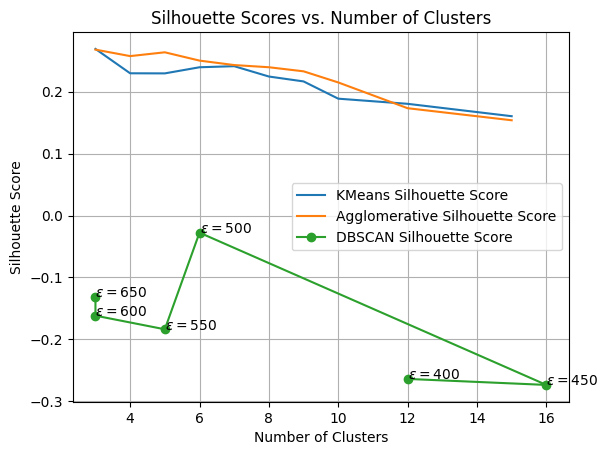

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(n_clusters, kmeans_silhouette_scores, label='KMeans Silhouette Score')
ax.plot(n_clusters, agglomerative_silhouette_scores, label='Agglomerative Silhouette Score')
ax.plot(dbscan_n_clusters, dbscan_silhouette_scores, marker='o', linestyle='-', label='DBSCAN Silhouette Score') # Add DBSCAN plot

ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Scores vs. Number of Clusters')
ax.legend()
ax.grid(True)

# Add labels for DBSCAN points (epsilon values)
for i, eps in enumerate(epss):
    if dbscan_silhouette_scores[i] is not None:
        ax.text(dbscan_n_clusters[i], dbscan_silhouette_scores[i], f'$\epsilon={eps}$') # Formatted label

plt.show()

## Plot davies-bouldin scores


<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-2842395224.py:16: SyntaxWarning: invalid escape sequence '\e'
  ax.text(dbscan_n_clusters[i], dbscan_davies_bouldin_scores[i], f'$\epsilon={eps}$') # Formatted label


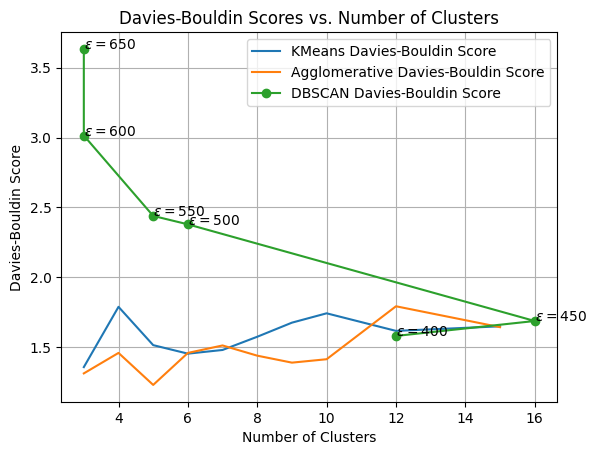

In [ ]:
fig, ax = plt.subplots()

ax.plot(n_clusters, kmeans_davies_bouldin_scores, label='KMeans Davies-Bouldin Score')
ax.plot(n_clusters, agglomerative_davies_bouldin_scores, label='Agglomerative Davies-Bouldin Score')
ax.plot(dbscan_n_clusters, dbscan_davies_bouldin_scores, marker='o', linestyle='-', label='DBSCAN Davies-Bouldin Score') # Add DBSCAN plot

ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Davies-Bouldin Score')
ax.set_title('Davies-Bouldin Scores vs. Number of Clusters')
ax.legend()
ax.grid(True)

# Add labels for DBSCAN points (epsilon values)
for i, eps in enumerate(epss):
    if dbscan_davies_bouldin_scores[i] is not None:
        ax.text(dbscan_n_clusters[i], dbscan_davies_bouldin_scores[i], f'$\epsilon={eps}$') # Formatted label

plt.show()

## Plot calinski-harabasz scores

<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-2673119292.py:16: SyntaxWarning: invalid escape sequence '\e'
  ax.text(dbscan_n_clusters[i], dbscan_calinski_harabasz_scores[i], f'$\epsilon={eps}$') # Formatted label


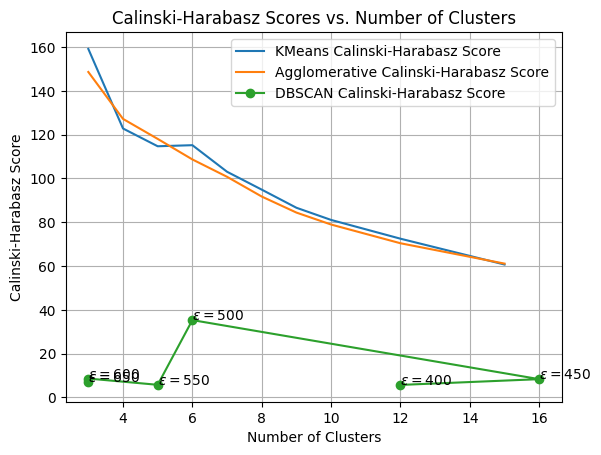

In [ ]:
fig, ax = plt.subplots()

ax.plot(n_clusters, kmeans_calinski_harabasz_scores, label='KMeans Calinski-Harabasz Score')
ax.plot(n_clusters, agglomerative_calinski_harabasz_scores, label='Agglomerative Calinski-Harabasz Score')
ax.plot(dbscan_n_clusters, dbscan_calinski_harabasz_scores, marker='o', linestyle='-', label='DBSCAN Calinski-Harabasz Score') # Add DBSCAN plot

ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Calinski-Harabasz Score')
ax.set_title('Calinski-Harabasz Scores vs. Number of Clusters')
ax.legend()
ax.grid(True)

# Add labels for DBSCAN points (epsilon values)
for i, eps in enumerate(epss):
    if dbscan_calinski_harabasz_scores[i] is not None:
        ax.text(dbscan_n_clusters[i], dbscan_calinski_harabasz_scores[i], f'$\epsilon={eps}$') # Formatted label


plt.show()

## Summary:

### Data Analysis Key Findings

The K-means and Agglomerative clusterings performed far better than the density based clustering, so I feel like I could exclude the latter from further analysis.\
When it comes to number of clusters in the first two methods, from internal evaluation scores it would seem better to have fewer clusters, but it is not definitive since there's still some variation, furthermore we don't know which model would perform better in a prediction of the future conditions.\
Fewer clusters might be good for having good internal scores but not useful in actual predictions.

So I will choose two n_clusters and use these for both methods to see which one predicts future flows best.

## Visualization of chosen clusters
Further analysis is carried out on 4 and 8 clusters for both **agglomerative** and **k-means** to get a sense of how much the number of clusters influences the prediction power of this model. Also I will now show a few visualizations of how each model clustered the data.

cluster_id_weekdays_share [62, 9, 87, 78]
cluster_id_weekend_share [1, 77, 0, 23]
111


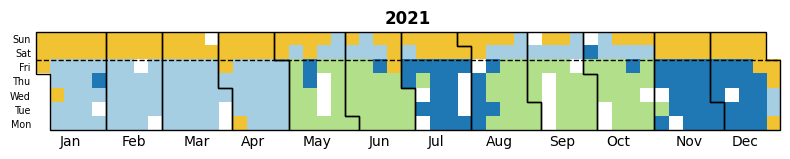

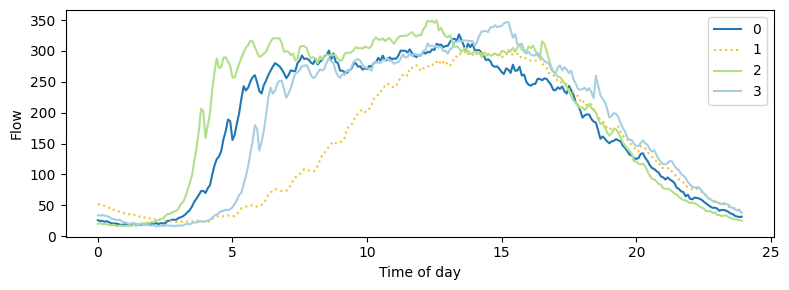

cluster_id_weekdays_share [31, 128, 6, 71]
cluster_id_weekend_share [55, 0, 46, 0]
111


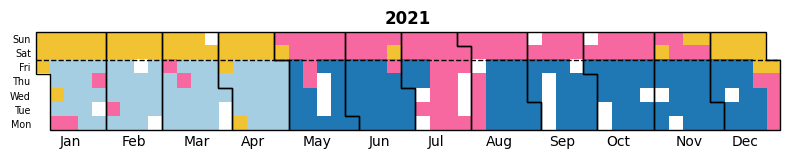

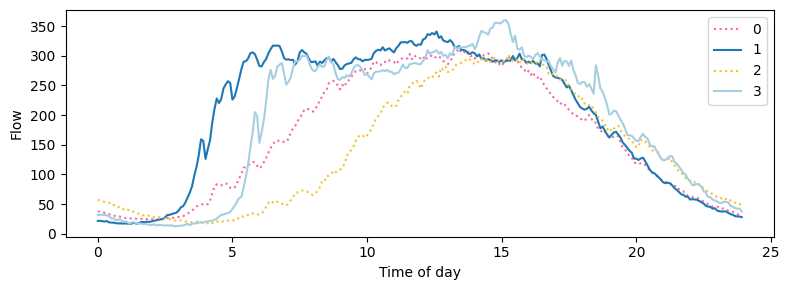

cluster_id_weekdays_share [32, 4, 79, 70, 6, 10, 34, 1]
cluster_id_weekend_share [0, 43, 0, 0, 39, 17, 0, 2]
111


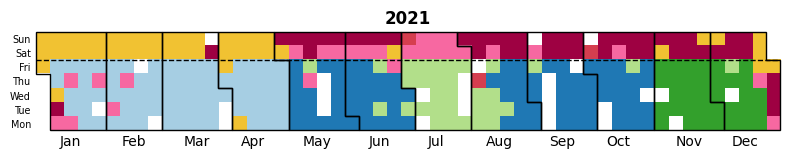

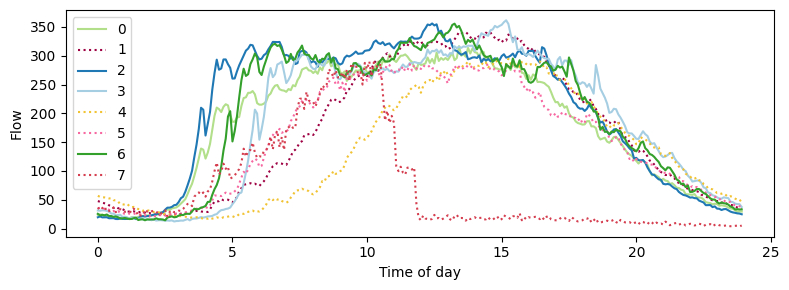

cluster_id_weekdays_share [6, 25, 90, 71, 1, 5, 5, 33]
cluster_id_weekend_share [46, 11, 0, 0, 2, 0, 42, 0]
111


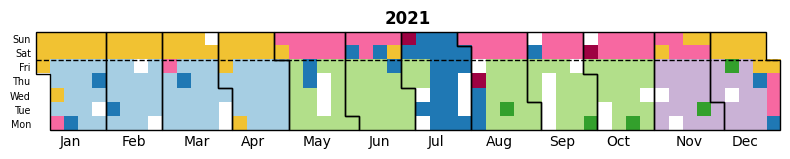

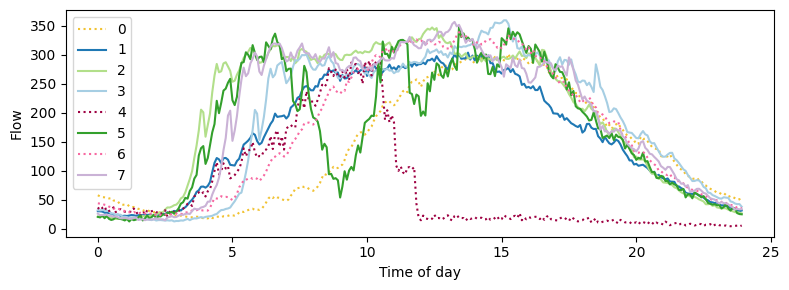

In [ ]:
methods=[k_means, agglomerative]
n_clusters=[4,8]

for n in n_clusters:
  for m in methods:
    # Initialize empty lists to store centroid data
    centroids_xx = []  # x-axis values for centroids
    centroids_yy_daytypes = []  # y-axis values for centroids, grouped by day types
    cluster_ids = []  # Cluster IDs
    for i in range(0, n):
      # Store the x-axis values for centroids (hours of the day)
      centroids_xx.append(x_axis_hours)

      # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
      centroid_yy = list(np.nanmean(dataset[np.where(m[n]['labels'] == i)[0], :], 0).transpose())
      centroids_yy_daytypes.append(centroid_yy)

      # Store the cluster ID
      cluster_ids.append(i)
    #-----------------------------------------

    days_colors, color_to_cluster, style_to_cluster = assign_colors(len(np.unique(m[n]['labels'])), days_not_nans, m[n]['labels'])

    make_calendar_visualization_figure(days_not_nans, m[n]['labels'], m[n]['n_clust'], [2021], days_colors,
                                        color_to_cluster, save_figure=None)

    make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)

## External evaluation with short-term prediction

So far, we have evaluated our clusters internally using metrics like silhouette score. But how do we know if these discovered "day-types" are actually useful for a real-world task? Do centroids improve one-step-ahead forecasting relative to meaningful baselines?

The idea is simple: if our centroids truly capture meaningful patterns, they should provide a good "baseline" prediction for what traffic will look like in the very near future. We will test this by using the centroids to predict the next 5-minute interval, a common task in traffic management systems.

First, lets load the evaluation dataset used of evaluating short-term prediction accuracy, vectorize it to day vectors and remove missing values.

In [ ]:
# Read the evaluation dataset from a CSV file
data_eval_df = pd.read_csv("/content/evaluation_dataset_exercise_5_clustering_highway_traffic.csv", sep=";")

# Sort the evaluation DataFrame by columns "Date" and "Interval_5"
data_eval_df.sort_values(["Date", "Interval_5"])

# Extract unique dates from the sorted evaluation DataFrame
days_eval = np.unique(data_eval_df[['Date']].values.ravel())
# Calculate the total number of unique days in the evaluation dataset
ndays_eval = len(days_eval)

# Group the evaluation DataFrame by the "Date" column
day_eval_subsets_df = data_eval_df.groupby(["Date"])

# Initialize a matrix 'vectorized_day_dataset_eval' filled with NaN values
vectorized_day_dataset_eval = np.zeros((ndays_eval, nintvals))
vectorized_day_dataset_eval.fill(np.nan)
# This section initializes a 2D array to store the evaluation dataset and fills it with NaN values.

# Loop through each unique day in the evaluation dataset
for i in range(0, ndays_eval):
    # Get the DataFrame corresponding to the current day
    df_t = day_eval_subsets_df.get_group(days_eval[i])

    # Loop through each row in the current day's DataFrame
    for j in range(len(df_t)):
        # Get the current day's DataFrame (this line is redundant)
        df_t = day_eval_subsets_df.get_group(days_eval[i])

        # Extract the "Interval_5" and "flow" values and populate 'vectorized_day_dataset_eval'
        vectorized_day_dataset_eval[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]

# Print the resulting 'vectorized_day_dataset_eval'
print(vectorized_day_dataset_eval)

/tmp/ipython-input-1974567836.py:23: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_t = day_eval_subsets_df.get_group(days_eval[i])
/tmp/ipython-input-1974567836.py:28: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_t = day_eval_subsets_df.get_group(days_eval[i])


[[35. 29. 32. ... 62. 66. 71.]
 [44. 44. 51. ... 30. 31. 23.]
 [21. 22. 17. ... 20. 22. 22.]
 ...
 [17. 17. 20. ... 35. 25. 27.]
 [37. 25. 30. ... 37. 36. 49.]
 [42. 28. 32. ... 45. 49. 38.]]


In [ ]:
# Calculate the total number of NaN values in the evaluation dataset
print('Number of NaNs:', np.sum(np.isnan(vectorized_day_dataset_eval)))

# Calculate the rate of NaN values in the evaluation dataset
print('Rate of NaNs:', np.sum(np.isnan(vectorized_day_dataset_eval)) / (ndays_eval * nintvals))

# Calculate the number of days with missing values
nans_per_day_eval = np.sum(np.isnan(vectorized_day_dataset_eval), 1)
print('Number of days with missing values:', np.size(np.where(nans_per_day_eval > 0)))

# Filter out days with no missing values and create a new dataset
vectorized_day_dataset_no_nans_eval = vectorized_day_dataset_eval[np.where(nans_per_day_eval == 0)[0], :]
days_not_nans_eval = days_eval[np.where(nans_per_day_eval == 0)[0]]

# Calculate the final number of days in the evaluation dataset after removing missing values
print('Final number of days in evaluation dataset:', len(days_not_nans_eval))

# Print the list of days in the evaluation dataset with no missing values
print('List of days without missing values:', days_not_nans_eval)

# Calculate the total number of days in the filtered evaluation dataset
ndays_eval_not_nans = len(days_not_nans_eval)

Number of NaNs: 96
Rate of NaNs: 0.004166666666666667
Number of days with missing values: 11
Final number of days in evaluation dataset: 69
List of days without missing values: [20220108 20220109 20220131 20220204 20220209 20220210 20220211 20220223
 20220226 20220227 20220302 20220304 20220305 20220306 20220310 20220314
 20220315 20220321 20220323 20220326 20220403 20220406 20220416 20220418
 20220421 20220422 20220425 20220427 20220428 20220503 20220505 20220514
 20220519 20220521 20220522 20220526 20220530 20220601 20220603 20220609
 20220616 20220619 20220623 20220628 20220704 20220711 20220712 20220904
 20220910 20220911 20220920 20220921 20220925 20220927 20220929 20220930
 20221005 20221022 20221024 20221114 20221116 20221121 20221122 20221213
 20221216 20221218 20221220 20221223 20221230]


Now when the dataset for evaluation is ready, below is a script for evaluating short-term prediction performance.

We will implement a specific forecasting strategy:

For each 5-minute interval j in a new day:

1. Look at the recent past: We take the actual observed traffic flow from the last 5 intervals (the last 25 minutes: j-4 to j).

2. Find the best-matching pattern: We compare this short recent history against the beginning of each of our four cluster centroids. The centroid whose first j+1 intervals most closely match the recent past is selected as our "best guide" for what should happen next.

3. Make a prediction: We use the value of the best-matching centroid at the next time interval (j+1) as our prediction.

4. Measure error: We compare this prediction to the actual observed traffic flow at interval j+1 and calculate the error.

We repeat this process for every possible interval in every day in our evaluation set. This tests the centroids' predictive power in a real context.

In [ ]:
# Import the pairwise_distances function from scikit-learn's metrics library
import sklearn.metrics.pairwise as dis_lib

# Define a function to find the closest centroid to a new data point within a specified day-time interval range
def find_the_closest_centroid(centroids, new_day, from_interval: int, to_interval: int):
    closest_centroid = None
    closest_dist = None

    # Iterate through each centroid
    for i in range(0, len(centroids)):
        # Calculate the Euclidean distance between the centroid and the new data point
        ed_t = dis_lib.paired_distances(centroids[i], new_day, metric='euclidean')

        # Check if the current centroid is closer than the previously closest one
        if closest_centroid is None or closest_dist > ed_t:
            closest_centroid = i
            closest_dist = ed_t

    return closest_centroid




Prediction accuracy MAE: 24.607666013093354
Prediction accuracy MAPE: 0.24531753390066866


In [ ]:
for n in n_clusters:
  for pippo,m in enumerate(methods):
    # Initialize a list to store centroid data
    centroids = []

    # Calculate centroids for each cluster
    for i in np.unique(m[n]['labels']):
        centroid = np.nanmean(dataset[np.where(m[n]['labels'] == i)[0], :], 0).reshape(1, nintvals)
        centroids.append(centroid)

    # Define the number of past intervals to consider for classification
    n_past_intervals_for_classification = 5

    # Initialize variables to calculate accuracy metrics
    total_mae = 0
    total_mape = 0
    prediction_counts = 0

    # Loop through each day in the evaluation dataset with no missing values
    for i in range(0, ndays_eval_not_nans):
        # Loop through intervals from n_past_intervals_for_classification to nintvals - 1
        for j in range(n_past_intervals_for_classification, nintvals - 1):
            # Find the closest centroid for the current data point
            centroid_index = find_the_closest_centroid(centroids, vectorized_day_dataset_no_nans_eval[i].reshape(1, nintvals), j - n_past_intervals_for_classification, j)

            # Predict the value for the next interval
            predicted_value = centroids[centroid_index][0, j + 1]

            # Calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)
            mae_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1])
            mape_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1]) / float(vectorized_day_dataset_no_nans_eval[i][j + 1])

            # Accumulate MAE, MAPE, and count of predictions
            total_mae += mae_t
            total_mape += mape_t
            prediction_counts += 1

    # Calculate and print the prediction accuracy metrics
    if pippo == 0:
      meth='k_means'
    else:
      meth='agglomerative'

    print(f'Clustering: {meth} with {n} clusters')
    print('Prediction accuracy MAE:', total_mae / prediction_counts)
    print('Prediction accuracy MAPE:', total_mape / prediction_counts)

Clustering: k_means with 4 clusters
Prediction accuracy MAE: 28.907917690806787
Prediction accuracy MAPE: 0.38827596645343576
Clustering: agglomerative with 4 clusters
Prediction accuracy MAE: 30.2079004369723
Prediction accuracy MAPE: 0.4020956386730881
Clustering: k_means with 8 clusters
Prediction accuracy MAE: 24.814128357783055
Prediction accuracy MAPE: 0.24671258798480053
Clustering: agglomerative with 8 clusters
Prediction accuracy MAE: 24.801209821915926
Prediction accuracy MAPE: 0.23961158835129007


External evaluation quantifies the performance of the day types with their centroids, which provides generalized data model of the dataset. Furthermore, it enables the comparison of various clusterings. The better the prediction performance, the more effectively the cluster-based prediction model captures important representative patterns, and also allows for better classification of unseen partial days. This score is closer to the objective of finding representative day-types, as are the internal evaluation scores, because it measures the predictive power of recognized representative patterns, but also the classification of unseen days (by Euclidean distance in this case)